## Assignment 8

# Development of optimal smoothing to increase the estimation accuracy

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of Assignment 8 is to develop algorithms to improve Kalman filter estimates, that is of prime importance for many practical control and forecasting problems. This will bring about a deeper understanding of main difficulties of practical Kalman filter implementation and skills to overcome these difficulties to get optimal assimilation output.**

In [11]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import copy

**Firstly, we generate a true trajectory $x_i$ of an object motion disturbed by normally distributed random acceleration and measurements $z_i$ of the coordinate $x_i$:**

In [12]:
def motion(initialX,initialV,initialT,lambdaVal,internalNoiseSigma,size):
    x = [initialX]
    v = [initialV]
    acceleration = 0
    for i in range(1,size):
        x.append(x[i - 1] + v[i - 1]*initialT + acceleration*initialT**2/2)
        v.append(v[i - 1] + acceleration * initialT)
        acceleration = np.random.normal(0, internalNoiseSigma)
    return x,v

def measurements(process,lambdaVal,T,measSigma):
    meas = process.copy()
    noise = 0
    for i in range(0,len(meas)):
       #noise = noise*np.exp(-lambdaVal*T) + np.random.normal(0,1)*measSigma*(1 - np.exp(-2*lambdaVal*T))**0.5
        meas[i] = meas[i] + np.random.normal(0,measSigma)
    return meas

In [13]:
# Initial conditions

T = 1
size = 200
initialX_1 = 5
initialV_1 = 1
internalNoiseSigma_1 = 0.2
externalNoiseSigma = 20
lambda_1 = 1000
lambda_4 = 0.1

**Some helpful functions which help us develop Kalman filter algorithm and visualize data:**

In [14]:
# Function which takes two processes as input and returns their combination as a vector
def giveVectors(processX,processV):
    X = []
    lastIndexX = len(processX) - 1
    lastIndexV = len(processV) - 1
    for i in range(0,max(lastIndexX + 1,lastIndexV + 1)):
        x = [[],[]]
        if(lastIndexX < i):
            x[0].append(0)
        else:
            x[0].append(processX[i])
        if(lastIndexV < i):
            x[1].append(0)
        else:
            x[1].append(processV[i])
        X.append(np.matrix((x)))
    return X

# Function which takes a vector as input and returns values from a specified axis
def giveElements(vectors,index):
    x = []
    for i in range(0,len(vectors)):
        x.append((vectors[i][index].item(0)))
    return x

# Function which returns a vector 
def giveAnyVectors(arr):
    X = []
    max_len = len(max(arr,key = lambda x: len(x)))
    for i in range(0,max_len):
        x = [[] for j in range(0,len(arr))]
        for j in range(0,len(arr)):
            if(len(arr[j]) <= i):
                x[j].append(0)
            else:
                x[j].append(arr[j][i])
        X.append(np.matrix((x)))
    return X

# Plotting function
def showPlease(arr,legend = [],xlabel ="x",ylabel="y",title="title"):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend)
    plt.title(title, fontsize = 16);
    plt.show()

**In order to present the system at state space, we introduce F - transition matrix that relates $X_i$ and $X_{i-1}$, G - input matrix that determines how random acceleration $a_i$ affects state vector, H - observation matrix:**

In [15]:
F_2 = np.matrix([[1,T],
                 [0,1]])
G_2 = np.matrix([[0],
                 [1]])
H_2 = np.matrix([[1,0]])

**Now, we develop Kalman filter algorithm to estimate state vector $X_i$ with given initial filtered estimate and initial filtration error covariance matrix:**

In [16]:
initialKalmanX_2v1 = np.matrix([[2],
                                [0]])
initialP_2v1 = np.matrix([[10000,0],
                          [0,10000]])

**Now the algorithm includes the function which conducts smoothing of the estimates. Smoothing procedure is performed backward in time and is applied to forward Kalman filter estimates:**

In [36]:
class KalmanFilter:
    def __init__(self,initialX,initialP,measStates,trueTrajectory,typeofProcess,noiseSigma,vectorK,H,
                F,measSigma,G,lambdaProcess,v):
        self.trueTrajectory = trueTrajectory.copy()
        self.measTrajectory = giveElements(measStates,0)
        self.kalmanStates = []
        self.listP = []
        self.listK = []
        self.noiseSigma = noiseSigma
        self.measSigma = measSigma
        self.R = self.giveR()
        self.F = F
        self.H = H
        self.G = G
        self.trueV = v.copy()
        self.lambdaProcess= lambdaProcess
        self.transitionalP = []
        prevX = initialX.copy()
        prevP = initialP.copy()
        if(len(vectorK)):
            K = vectorK
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                self.transitionalP.append(predictedP)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        else:
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                self.transitionalP.append(predictedP)
                K = self.giveK(predictedP,self.giveH(i),self.R)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        self.kalmanTrajectory = giveElements(self.kalmanStates,0)
        
    def giveK(self):
        return self.listK.copy()
    
    def extrapolate(self,step):
        predictions = []
        for i in range(step-1,len(self.trueTrajectory)):
            predictions.append((self.giveF(i,i - 1)**(step - 1))*self.kalmanStates[i - step + 1])
        return predictions
    
    def errorsSq(self,listValues):
        start = 0
        errors = []
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append((self.trueTrajectory[i] - listValues[i - start ])**2)
        return errors
    
    def errorsVSq(self,listValues):
        start = 0
        errors = []
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append((self.trueV[i] - listValues[i - start ])**2)
        return errors
    
    def giveQ(self,index,typeOfProcess,noiseSigma):#
        G = self.G
        if(typeOfProcess == "det"):
            return 0
        else:
            return G*G.T*(noiseSigma**2)*(1 - np.exp(-2*self.lambdaProcess))
        
    def giveK(self,predictedP,H,R):#
        return predictedP*H.T*(H*predictedP*H.T + R)**(-1)
    
    def giveR(self):#
        return self.measSigma**2
    
    def giveH(self,index):#
        return self.H
    
    def giveF(self,firstIndex,secondIndex):#
        return self.F
    
    def predict(self,prevX,prevP,F,Q):
        x = F*prevX
        P = F*prevP*F.T + Q
        return x,P
    
    def filtrate(self,predictedX,predictedP,K,meas,H,R):
        x = predictedX + K*(meas - H*predictedX)
        KH = K*H
        P = (np.identity(KH.shape[0]) - KH) * predictedP
        return x,P
    
    def givePError(self):
        p = []
        dimension = len(self.listP[0])
        for i in self.listP:
            x = [[] for j in range(0,dimension)]
            for j in range(0,dimension):
                x[j].append((i.item(j,j))**0.5)
            p.append(np.matrix(x))
        return p
    
    def givePBackError(self):
        p = []
        dimension = len(self.listP[0])
        for i in self.PBack:
            x = [[] for j in range(0,dimension)]
            for j in range(0,dimension):
                x[j].append((i.item(j,j))**0.5)
            p.append(np.matrix(x))
        return p
    
    def smooth(self):
        PBack = [self.listP[-1]]
        xBack = [self.kalmanStates[-1]]
        for i in range(len(self.listP)-2,-1,-1):
            A = self.listP[i]*self.F.T*(self.transitionalP[i+1]**(-1))
            x = self.kalmanStates[i] + A * (xBack[-1] - self.F * self.kalmanStates[i])
            P = self.listP[i] + A * (PBack[-1] - self.transitionalP[i+1]) * A.T
            PBack.append(P)
            xBack.append(x)
        self.PBack = PBack[::-1].copy()
        self.xBack = xBack[::-1].copy()
        return self

In [22]:
# Function which runs the algorithm

def createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G,lambdaProcess,lambdaMeas):
    processX,processV = motion(initialX,initialV,initialT,lambdaProcess,noiseSigma,size)
    meas = measurements(processX,lambdaMeas,0,measSigma)
    states = giveVectors(meas,[])
    return KalmanFilter(initialKalmanX,initialP,states,processX,typeOfProcess,noiseSigma,vectorK,H,F,measSigma,G,lambdaProcess,processV)


# Function which runs the algorithm M times and calculates mean-squared error of estimation (true estimation error) 
# over observation interval

def manyKalman(size,amount,initialX,initialV,initialT,noiseSigma,measSigma,
               initialKalmanX,initialP,predictStep,typeOfProcess,vectorK,H,F,G,lambdaProcess,lambdaMeas):
    filteredErrorsTotal = [0 for x in range(2,size)]
    filteredErrorsVTotal = [0 for x in range(0,size)]
    smoothedErrorTotal =  [0 for x in range(0,size)]
    smoothedErrorTotalV =  [0 for x in range(0,size)]
    for i in range(0,amount):
        kalman = createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G,lambdaProcess,lambdaMeas)
        filteredErrors = kalman.errorsSq(kalman.kalmanTrajectory)
        kalman.smooth()
        filteredErrorsV = kalman.errorsVSq(giveElements(kalman.kalmanStates,1))
        smoothedError = kalman.errorsSq(giveElements(kalman.xBack,0))
        smoothedErrorV = kalman.errorsVSq(giveElements(kalman.xBack,1))
        for j in range(2,size):
            filteredErrorsTotal[j - 2] = filteredErrorsTotal[j - 2] + filteredErrors[j]
        for j in range(0,size):
            filteredErrorsVTotal[j] = filteredErrorsVTotal[j] + filteredErrorsV[j]
        for j in range(0,size):
            smoothedErrorTotal[j] = smoothedErrorTotal[j] + smoothedError[j]
        for j in range(0,size):
            smoothedErrorTotalV[j] = smoothedErrorTotalV[j] + smoothedErrorV[j]
    for i in range(0,len(filteredErrorsTotal)):
        filteredErrorsTotal[i] = (filteredErrorsTotal[i]/(amount - 1))**0.5
    for i in range(0,size):
        filteredErrorsVTotal[i] = (filteredErrorsVTotal[i]/(amount - 1))**0.5
    for i in range(0,size):
        smoothedErrorTotal[i] = (smoothedErrorTotal[i]/(amount - 1))**0.5
    for i in range(0,size):
        smoothedErrorTotalV[i] = (smoothedErrorTotalV[i]/(amount - 1))**0.5
    return filteredErrorsTotal, filteredErrorsVTotal, smoothedErrorTotal, smoothedErrorTotalV

**Now we run the algorithm:**

In [23]:
k = createProcessGiveKalman(size,initialX_1,initialV_1,T,internalNoiseSigma_1,externalNoiseSigma,initialKalmanX_2v1,
                            initialP_2v1,"usual",[],H_2,F_2,G_2,1000,1000)

**and smoothing:**

In [41]:
k.smooth();

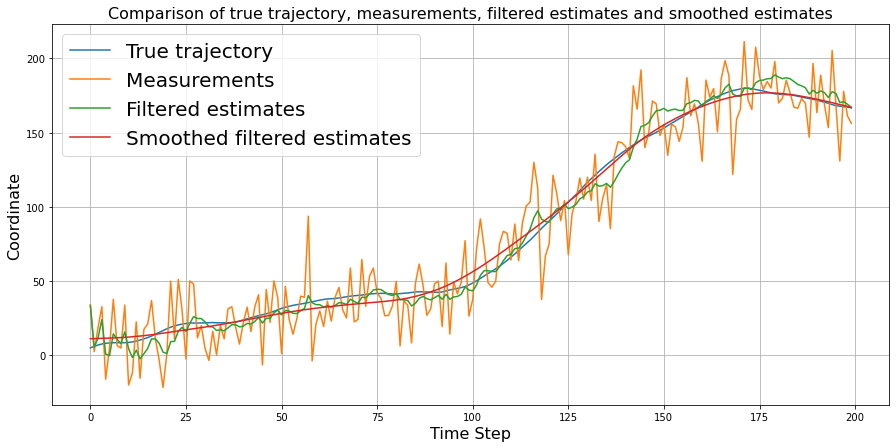

In [43]:
showPlease([k.trueTrajectory,k.measTrajectory,giveElements(k.kalmanStates,0), giveElements(k.xBack,0)],
           ['True trajectory','Measurements','Filtered estimates', 'Smoothed filtered estimates'], 
           'Time Step', 'Coordinate',
           'Comparison of true trajectory, measurements, filtered estimates and smoothed estimates')

**Kalman filter algorithm not only provides us with quite accurate filtered estimates, but also with even more accurate smoothed ones. In order to have a closer look on the results, let us compare only true trajectory and smoothed estimates lines:**

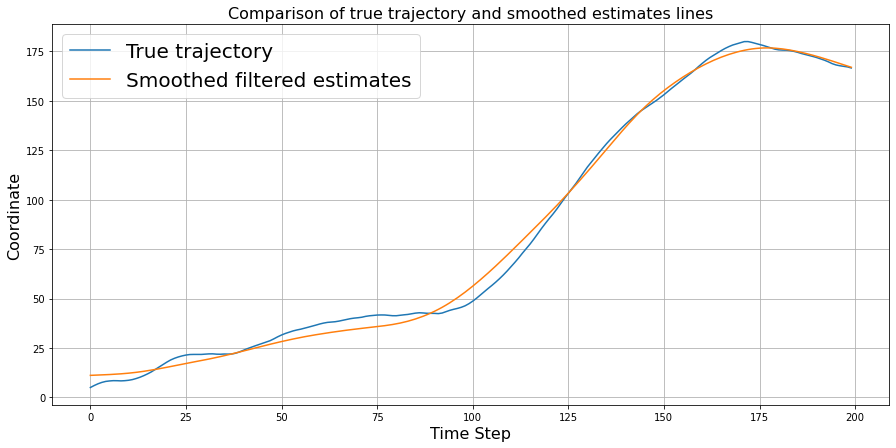

In [44]:
showPlease([k.trueTrajectory, giveElements(k.xBack,0)],
           ['True trajectory', 'Smoothed filtered estimates'], 
           'Time Step', 'Coordinate',
           'Comparison of true trajectory and smoothed estimates lines')

**It is seen from the graph that optimal smoothing line correctly and accurately describes the trend of the true trajectory. In order to get a better understanding of accuracy of the results, let us compare true estimation error with errors of
smoothing by running smoothing procedure for M = 500 times:**

In [46]:
filteredErrors,filteredErrorsV,smoothXErrors,smoothVErrors = manyKalman(size,500,initialX_1,initialV_1,T,internalNoiseSigma_1,
                  externalNoiseSigma,initialKalmanX_2v1,initialP_2v1,7,"usual",[],H_2,F_2,G_2,1000,1000)

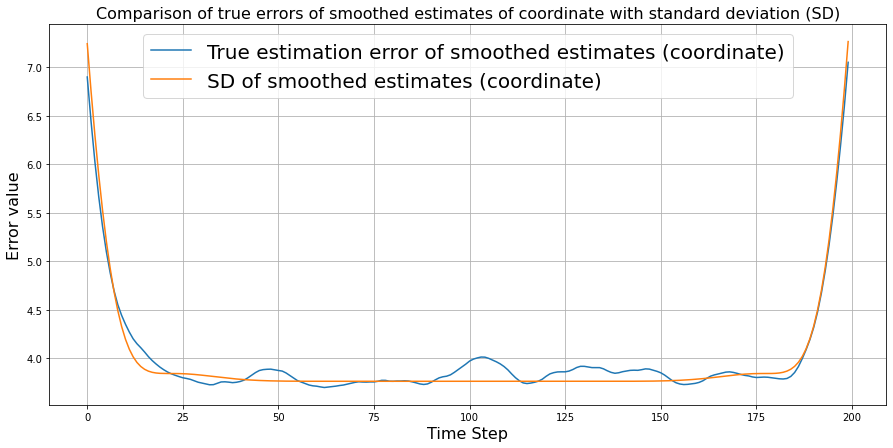

In [49]:
xErrorsP = giveElements(k.givePBackError(),0)
showPlease([smoothXErrors,xErrorsP],["True estimation error of smoothed estimates (coordinate)",
           'SD of smoothed estimates (coordinate)'],
           'Time Step', 'Error value', 
           'Comparison of true errors of smoothed estimates of coordinate with standard deviation (SD)');

**True estimation errors of smoothed estimates of coordinate correspond to standard deviation values - the filter reached its limit of accuracy significantly improving the results. High values of errors at the beginning and at the end of the time line correspond to some time needed for "tuning of the algorithm" for the former time part and "tuning of backward smoothing" for the latter time part. Let us compare true estimation errors of smoothed estimates of velocity with its standard deviation values:**

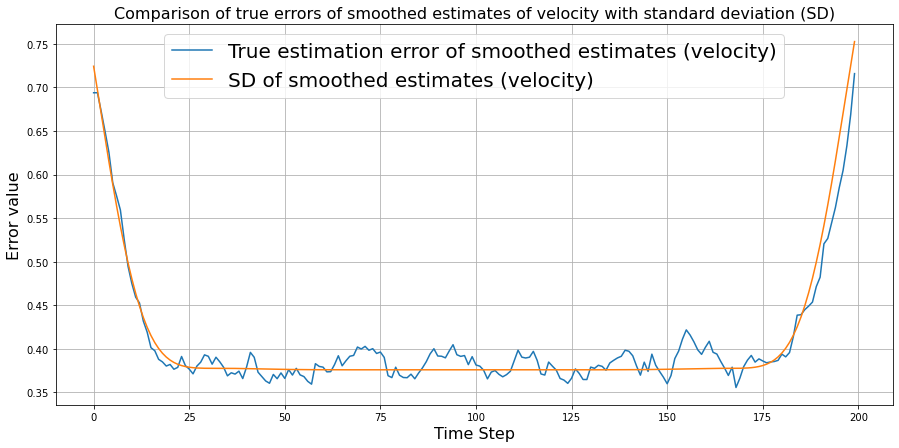

In [50]:
vErrorsP = giveElements(k.givePBackError(),1)
showPlease([smoothVErrors,vErrorsP],["True estimation error of smoothed estimates (velocity)",
           'SD of smoothed estimates (velocity)'],
           'Time Step', 'Error value', 
           'Comparison of true errors of smoothed estimates of velocity with standard deviation (SD)');

**Although the line corresponding to true estimation error is fluctuating, we observe the same situation as with coordinate - all in all, the algorithm provides us with its best accuracy, the overall values of errors are quite low. Now let us compare smoothing errors of estimation with filtration errors of estimation to clearly see how smoothing increase accuracy of filtered estimates:**

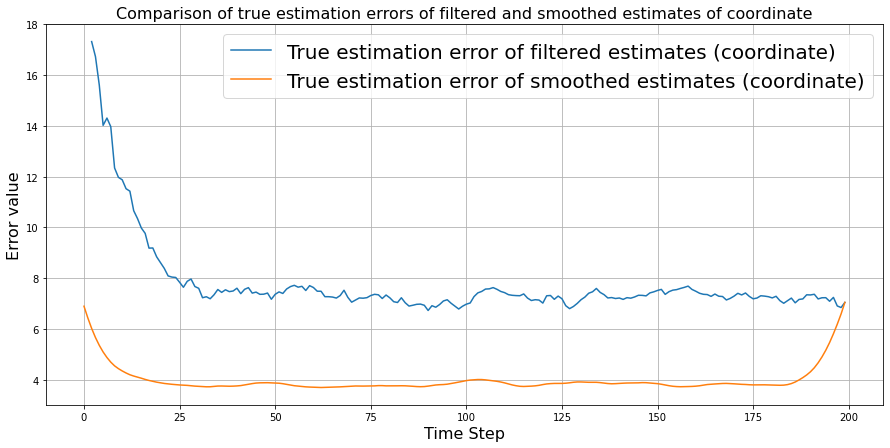

In [54]:
showPlease([filteredErrors,smoothXErrors],['True estimation error of filtered estimates (coordinate)',
           'True estimation error of smoothed estimates (coordinate)'],
           'Time Step', 'Error value', 
           'Comparison of true estimation errors of filtered and smoothed estimates of coordinate');

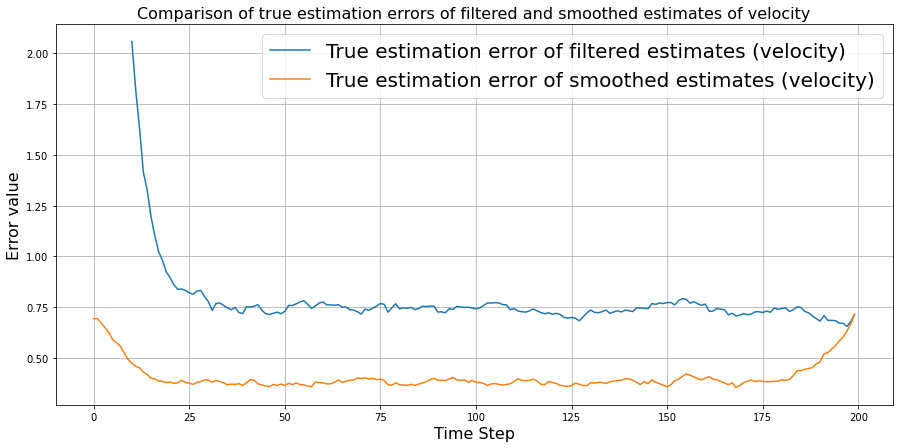

In [55]:
showPlease([filteredErrorsV[10:],smoothVErrors],['True estimation error of filtered estimates (velocity)',
           'True estimation error of smoothed estimates (velocity)'],
           'Time Step', 'Error value', 
           'Comparison of true estimation errors of filtered and smoothed estimates of velocity');

**The values of coordinate and velocity errors experience a significant decrease by ~2 and ~3 times, respectively, when smoothing procedure takes place. Thus, development of optimal smoothing leads to a noticeable increase of the estimation accuracy.**

**Conclusion: In order to obtain better estimation results, we learned how to develop Kalman algorithm which includes smoothing procedure. Firstly, we developed our usual Kalman algorithm but this time we added one more function to the filter class which runs the recurrent algorithm of smoothing. The smoothing was performed backward in time taking into account both current and future measurements, so we were basically working with filtration results as well as prediction outcomes of forward Kalman filter at the same time. It resulted in highly improved estimations - it was clearly seen even from the graph of true trajectory, measurements and filtered & smoothed estimates, that smoothing procedure provides us with the accurate slightly-fluctuated line in comparison with just filtered estimates line. Then, we observed that true estimation errors of both coordinate and velocity indeed correspond to the errors calculated by Kalman filter proving that the filter achieved its best accuracy level which turned out to be quite low. We also noted that this time there were increased error values from the both sides of time line and made an assumption that these high values of errors correspond to some time needed for "tuning of the algorithm" at the beginning of time line and "tuning of backward smoothing" at the end of time line. From the last two graphs of true estimation error comparison for filtered and smoothed coordinate/velocity, we distinctly saw how smoothing improved the accuracy as the values of errors dramaticaly dropped by ~2 times for coordinate and ~3 times for velocity. Thus, we made sure that smoothing procedure significantly improved estimation compared to Kalman filter. Moreover, this assignment taught us one more strategic approach: it is absolutely not worth it to look for an error in a code if there is one - it is much faster to rewrite the code from the very beginning than to waste time on the error search.**